In [1]:
from importlib import reload
import sys
import pickle
import numpy as np 
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
plt.ioff()
%matplotlib inline
import seaborn as sns
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pybedtools
from joblib import Parallel, delayed
from tqdm import tqdm
import time
from matplotlib_venn import venn3, venn3_circles
from upsetplot import from_contents
from upsetplot import UpSet
import fastcluster
from matplotlib_venn import venn3

# Data directories

In [3]:
cell_type = 'old_fibroblasts'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

In [2]:
genome_dir = '/home/braunger/masterthesis/data/genome_data/'
epigenome_dir = '/home/braunger/masterthesis/data/regulatory_data/regulatory_data_old_fibroblasts/'
processed_epigenome_data_dir = '/home/braunger/masterthesis/save/processed_regulatory_marks/processed_epigenome_data_old_fibroblasts/'
processed_hic_data_dir = '/home/braunger/masterthesis/save/processed_hic_data/processed_hic_data_old_fibroblasts/final_BP250000_intraKR_interINTERKR/'
PCs_dir = '/home/braunger/masterthesis/save/processed_hic_data/processed_hic_data_old_fibroblasts/intrachromosomal_PCs/'

# Determine active and inactive regions

### Correlations of PCs on observed/expected vs. correlation matrix

In [5]:
chr_list =  np.arange(1,22+1)
for chrom in chr_list:
    PCs = pd.read_csv(PCs_dir+'PCs_chr'+str(chrom)+'.csv', header=0, index_col = 0)
    PCs_corr = pd.read_csv(PCs_dir+'PCs_corr_chr'+str(chrom)+'.csv', header=0, index_col = 0)

    #Calculate correlation of PCs
    corr_PC1 = np.corrcoef(PCs.iloc[:, 0], PCs_corr.iloc[:, 0])[0,1]
    corr_PC2 = np.corrcoef(PCs.iloc[:, 1], PCs_corr.iloc[:, 1])[0,1]

    print("Correlation PC1 on chrom "+str(chrom)+": "+str(corr_PC1))
    print("Correlation PC2 on chrom "+str(chrom)+": "+str(corr_PC2))
    print()

Correlation PC1 on chrom 1: -0.5314610440256154
Correlation PC2 on chrom 1: -0.4688307414636234

Correlation PC1 on chrom 2: 0.9486688600788655
Correlation PC2 on chrom 2: 0.044295259819526915

Correlation PC1 on chrom 3: 0.9615366080861644
Correlation PC2 on chrom 3: -0.4901484541428304

Correlation PC1 on chrom 4: 0.8942040153131134
Correlation PC2 on chrom 4: 0.8347403832726008

Correlation PC1 on chrom 5: 0.9444103260170683
Correlation PC2 on chrom 5: 0.7880940816135036

Correlation PC1 on chrom 6: 0.9577117503223919
Correlation PC2 on chrom 6: -0.5903100491083964

Correlation PC1 on chrom 7: 0.9652181070513298
Correlation PC2 on chrom 7: 0.4981028713062605

Correlation PC1 on chrom 8: 0.9718454059002244
Correlation PC2 on chrom 8: 0.5033265001162988

Correlation PC1 on chrom 9: -0.2634053334744483
Correlation PC2 on chrom 9: -0.3303801729141994

Correlation PC1 on chrom 10: 0.9766272271171346
Correlation PC2 on chrom 10: 0.6562065209255278

Correlation PC1 on chrom 11: 0.971498253

### Load epigenomic data

In [8]:
# Helper function for loading principal component data
def get_PCs(PCs_dir, chrom, df_chipseq_norm, input_type):
    # load PCs
    if input_type == "correlation":
        PCs = pd.read_csv(PCs_dir+'PCs_corr_chr'+str(chrom)+'.csv', header=0, index_col = 0)
    else: 
        PCs = pd.read_csv(PCs_dir+'PCs_chr'+str(chrom)+'.csv', header=0, index_col = 0)
    
    # calculate correlation of the two PCs to the RNA-seq
    corr_PC1 = np.corrcoef(PCs.iloc[:, 0], df_chipseq_norm.loc['RNA-seq'])[0,1]
    corr_PC2 = np.corrcoef(PCs.iloc[:, 1], df_chipseq_norm.loc['RNA-seq'])[0,1]
    
    # choose between PC1 and PC2 the one with higher correlation and correct to positive correlation with RNA-seq
    if abs(corr_PC1) >= abs(corr_PC2):
        if corr_PC1 < 0:
            PC = -1 * PCs.iloc[:, 0]
        else:
            PC = PCs.iloc[:, 0]
    else:
        if corr_PC2 < 0:
            PC = -1 * PCs.iloc[:, 1]
        else:
            PC = PCs.iloc[:, 1]

    
    # create pd DataFrame
    PC = pd.DataFrame(PC).T
    if input_type == "correlation": 
        PC.index = ["PC_corr"]
    else:
        PC.index = ["PC"]
    PC.columns = df_chipseq_norm.columns
    return(PC)

In [9]:
# collect normalized epigenomic data across all chromosomes into one dataframe
df_all_norm = pd.DataFrame()
chr_list =  np.arange(1,22+1)
for chrom in chr_list:
    # get feature matrix per chromosome
    df_chipseq_norm = pd.read_csv(processed_epigenome_data_dir+'features_matrix_chr'+str(chrom)+'_norm.csv', header=0, index_col = 0)
    df_chipseq_norm.columns = 'chr_'+str(chrom)+'_loc_'+np.array(df_chipseq_norm.columns)
    # get PCs on intrachromosomal hic data
    PC = get_PCs(PCs_dir, chrom, df_chipseq_norm, "normal")
    # get PCs on correlation matrix of intrachromosomal hic data
    PC_corr = get_PCs(PCs_dir, chrom, df_chipseq_norm, "correlation")
    # add PC as feature
    df_chipseq_complete = pd.concat([df_chipseq_norm, PC, PC_corr], axis = 0)
    # Concatenate to data for previous chromosomes
    df_all_norm = pd.concat([df_all_norm, df_chipseq_complete],axis=1)

### Correlation between features

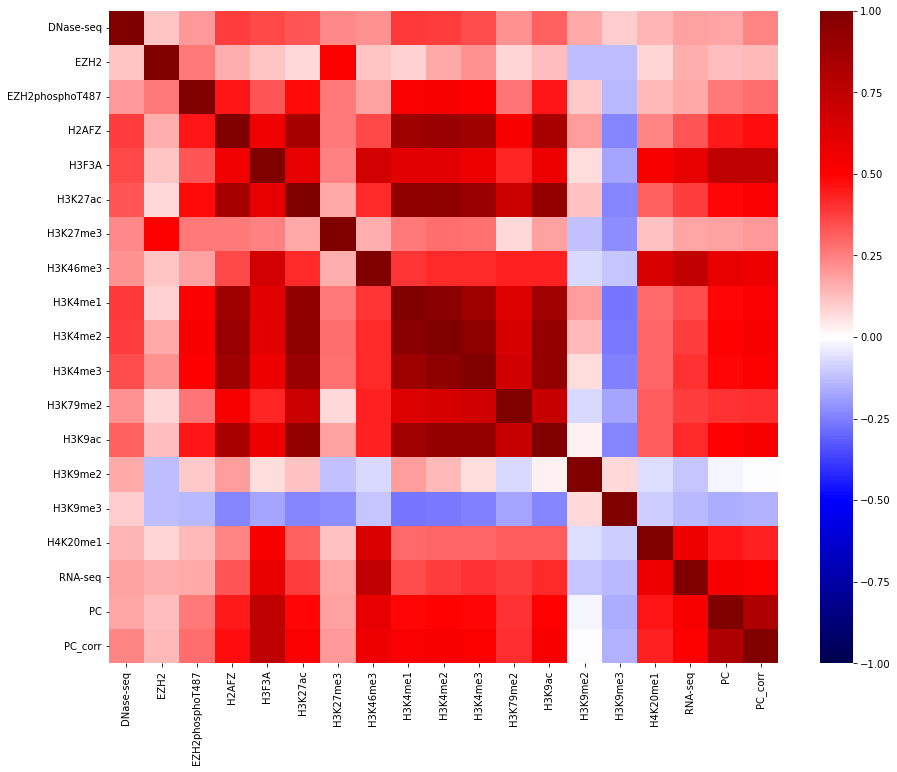

In [10]:
plt.figure(figsize = (15,12))
sns.heatmap(df_all_norm.T.corr(), cmap = "seismic", vmin = -1, vmax = 1)
plt.show()

In [11]:
# Correlation between PC based on observed/expected vs based on correlation matrix
df_all_norm.T.corr().loc["PC", "PC_corr"]

0.8147647849734316

### Correlation to RNAseq

In [14]:
df_all_norm.T.corr().loc["RNA-seq", "PC"]

0.5259192011867013

In [15]:
df_all_norm.T.corr().loc["RNA-seq", "PC_corr"]

0.5098520760967433